<a href="https://colab.research.google.com/github/aaderemi/GSoC/blob/main/selfsup_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget https://www.dropbox.com/scl/fi/4zmsw47g0qvyk2p801pnq/data_Adeola_July21.zip?rlkey=ve5oufd1b5hy7x411c9l29led&st=fc67d5ep&dl=0

--2024-07-25 12:09:37--  https://www.dropbox.com/scl/fi/4zmsw47g0qvyk2p801pnq/data_Adeola_July21.zip?rlkey=ve5oufd1b5hy7x411c9l29led
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1d4874ade1d7b1d05abbc144cd.dl.dropboxusercontent.com/cd/0/inline/CXV-_uWp1jIraoMaUtbIcGQeckpumu7Jba-_44hm9Px-9oOLxZvr1MpODVTJgWBineivFp-91LNcoElN4RZKlGIjIwos_jeCkQtvTV5iloxEz-o_ZTsTRITxKTcegVzHGAvdHHomIzmtYUG89ssn_TvK/file# [following]
--2024-07-25 12:09:38--  https://uc1d4874ade1d7b1d05abbc144cd.dl.dropboxusercontent.com/cd/0/inline/CXV-_uWp1jIraoMaUtbIcGQeckpumu7Jba-_44hm9Px-9oOLxZvr1MpODVTJgWBineivFp-91LNcoElN4RZKlGIjIwos_jeCkQtvTV5iloxEz-o_ZTsTRITxKTcegVzHGAvdHHomIzmtYUG89ssn_TvK/file
Resolving uc1d4874ade1d7b1d05abbc144cd.dl.dropboxusercontent.com (uc1d4874ade1d7b1d05abbc144cd.dl.dropboxusercontent.com)... 162.125.65

In [ ]:
!unzip /content/data_Adeola_July21.zip -d /content/blaes_data

Archive:  /content/data_Adeola_July21.zip
   creating: /content/blaes_data/BLAES_test/
   creating: /content/blaes_data/BLAES_test/BJ_imageset2/
  inflating: /content/blaes_data/BLAES_test/BJ_imageset2/Events.npy  
  inflating: /content/blaes_data/BLAES_test/BJ_imageset2/StudyOutcomes.csv  
  inflating: /content/blaes_data/BLAES_test/BJ_imageset2/FoundationData.npy  
   creating: /content/blaes_data/BLAES_test/UIC2_imageset1/
  inflating: /content/blaes_data/BLAES_test/UIC2_imageset1/Events.npy  
  inflating: /content/blaes_data/BLAES_test/UIC2_imageset1/StudyOutcomes.csv  
  inflating: /content/blaes_data/BLAES_test/UIC2_imageset1/FoundationData.npy  
   creating: /content/blaes_data/BLAES_test/UIC1_imageset1/
  inflating: /content/blaes_data/BLAES_test/UIC1_imageset1/Events.npy  
  inflating: /content/blaes_data/BLAES_test/UIC1_imageset1/StudyOutcomes.csv  
  inflating: /content/blaes_data/BLAES_test/UIC1_imageset1/FoundationData.npy  


In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 76.1 MB/s eta 0:00:00


In [ ]:
data_path = "/content/blaes_data/BLAES_test"

In [ ]:
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
import mne

In [ ]:
class CustomBIPDataset(Dataset):
    def __init__(self, file_paths, labels):
        self.data = []
        self.labels = []
        for data_path, label_path in zip(file_paths, labels):
            foundation_data = np.load(data_path)
            # events_data = np.load(label_path)
            events_data = pd.read_csv(label_path)["Outcome"].to_list()
            # or np.isnan(events_data).any():
            if np.isnan(foundation_data).any():
                print(
                    f"\nNaN values found in data: {data_path} or {label_path} !!!!!!!")
                continue  # Skip this data

            M = foundation_data.shape[0]

            # slices = foundation_data[:, :, 3101:4001]
            slices = foundation_data[:, np.r_[0:9, 19], 3101:4001]
            for i in range(M):
                self.data.append(slices[i])
                # if events_data[i, -1] == 0:
                #     self.labels.append(0)
                # elif events_data[i, -1] == 1:
                #     self.labels.append(1)
                if events_data[i] == "Miss":
                    self.labels.append(0)
                elif events_data[i] == "Hit":
                    self.labels.append(1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = torch.tensor(self.data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        # print("sample shape is: ", sample.shape)
        # print("label is: ", label)
        return sample, label


def get_subject_paths(base_dir):
    subject_paths = []
    walk_list = list(os.walk(base_dir))
    sorted_walk_list = sorted(walk_list, key=lambda x: x[0])

    for root, dirs, files in sorted_walk_list:
        if 'FoundationData.npy' in files and 'Events.npy' in files:
            subject_paths.append(root)
    return subject_paths


def load_data(base_dir):
    subject_paths = get_subject_paths(base_dir)
    foundation_files = [os.path.join(path, 'FoundationData.npy')
                        for path in subject_paths]
    # event_files = [os.path.join(path, 'Events.npy') for path in subject_paths]
    event_files = [os.path.join(path, 'StudyOutcomes.csv')
                   for path in subject_paths]
    subjects = [os.path.basename(path).split('_')[0] for path in subject_paths]
    # subjects = [x for x in subjects if x != 'BJH018']
    return foundation_files, event_files, subjects

In [ ]:
foundation_files, event_files, subjects = load_data(data_path)

In [ ]:
foundation_files[0], event_files[0]

('/content/blaes_data/BLAES_test/BJ_imageset2/FoundationData.npy',
 '/content/blaes_data/BLAES_test/BJ_imageset2/StudyOutcomes.csv')

In [ ]:
subjectzero = CustomBIPDataset(foundation_files[0:1], event_files[0:1])
subjectone = CustomBIPDataset(foundation_files[1:2], event_files[1:2])
subjecttwo = CustomBIPDataset(foundation_files[2:3], event_files[2:3])

In [ ]:
subjectzero_data, subjectzero_labels = np.array(subjectzero.data), np.array(subjectzero.labels)
subjectone_data, subjectone_labels = np.array(subjectone.data), np.array(subjectone.labels)
subjecttwo_data, subjecttwo_labels = np.array(subjecttwo.data), np.array(subjecttwo.labels)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
from mne.filter import filter_data

In [ ]:
Fs = 500 #sampling frequency
num_channels = 10 #number of channels
num_outputs_model1 = 64
num_outputs_model2 = 56
pretraining_sample_size = 300
num_clusters = 4
model1_outputsize = 64

In [ ]:
subjectzero_data.shape, subjectone_data.shape, subjecttwo_data.shape

((153, 10, 900), (153, 10, 900), (153, 10, 900))

In [ ]:
def make_D_prime():
  X_train = np.concatenate([subjectzero_data[:, :num_channels, :], subjectone_data[:, :num_channels, :]])

  #X_train = np.reshape(X_train, newshape = (-1, 1, X_train.shape[-1]))

  num_train = X_train.shape[0]
  train_indices = np.random.RandomState(42).permutation(num_train)

  num_samples = pretraining_sample_size
  X_train = X_train[train_indices[:num_samples], ...]

  num_samples_per_class = num_samples//5

  classone_x = filter_data(X_train[:num_samples_per_class, :, :], sfreq = 500, l_freq = 4, h_freq = 0.5, verbose=False)
  classone_y = np.zeros(num_samples_per_class)

  classtwo_x = filter_data(X_train[num_samples_per_class:2*num_samples_per_class, :, :], sfreq = 500, l_freq = 8, h_freq = 4, verbose=False)
  classtwo_y = np.ones(num_samples_per_class)

  classthree_x = filter_data(X_train[2*num_samples_per_class:3*num_samples_per_class, :, :], sfreq = 500, l_freq = 15, h_freq = 8, verbose=False)
  classthree_y = np.ones(num_samples_per_class)*2

  classfour_x = filter_data(X_train[3*num_samples_per_class:4*num_samples_per_class, :, :], sfreq = 500, l_freq =30, h_freq = 15, verbose=False)
  classfour_y = np.ones(num_samples_per_class)*3

  classfive_x = filter_data(X_train[4*num_samples_per_class:5*num_samples_per_class, :, :], sfreq = 500, l_freq =59, h_freq = 30, verbose=False)
  classfive_y = np.ones(num_samples_per_class)*4

  output = [(classone_x, classone_y), (classtwo_x, classtwo_y), (classthree_x, classthree_y), (classfour_x, classfour_y), (classfive_x, classfive_y)]

  return output

In [ ]:
task1_data = make_D_prime()

<ipython-input-180-44308ab796e6>:14: RuntimeWarning: filter_length (3301) is longer than the signal (900), distortion is likely. Reduce filter length or filter a longer signal.
  classone_x = filter_data(X_train[:num_samples_per_class, :, :], sfreq = 500, l_freq = 4, h_freq = 0.5, verbose=False)


In [ ]:
def make_D_primeprime():
  X_train = np.concatenate([subjectzero_data[:, :num_channels, :], subjectone_data[:, :num_channels, :]])

  #X_train = np.reshape(X_train, newshape = (-1, 1, X_train.shape[-1]))

  num_train = X_train.shape[0]
  train_indices = np.random.RandomState(42).permutation(num_train)

  num_samples = pretraining_sample_size
  X_train = X_train[train_indices[:num_samples], ...]
  num_samples_per_class = num_samples//4

  def maf(x, window):

    x = np.squeeze(x) # to suppress the final dimension
    print(x.shape)
    for ns in range(x.shape[0]):
        for nc in range(x.shape[1]):
            x[ns, nc] -= np.convolve(x[ns, nc], np.ones(window), 'same') / window
    return x

  def trend(x, adding=True):
    if adding:
        tmp = 1
    else:
        tmp = -1
    x = np.squeeze(x)  # to suppress the final dimension
    for ns in range(x.shape[0]):
        for nc in range(x.shape[1]):
            x[ns, nc] += tmp * (np.random.random(1) * np.linspace(0, 0.5, x.shape[-1]) - 0.5)
    return x

  def cyclo(x):
    x = np.squeeze(x)  # to suppress the final dimension
    for ns in range(x.shape[0]):
        for nc in range(x.shape[1]):
            tmp = np.random.random(1)
            x[ns, nc] += (np.random.random(1) * np.sin(np.linspace(-np.pi + tmp, np.pi + tmp, x.shape[-1]))).squeeze()
    return x

    X[3 * int(num_samples / 4):, ...] = cyclo(X[3 * int(num_samples / 4):, ...])

  classone_x = maf(X_train[:num_samples_per_class, :, :], 20)
  classone_y = np.zeros(num_samples_per_class)

  classtwo_x1 = trend(X_train[num_samples_per_class:int(1.5*num_samples_per_class), :, :], True)
  classtwo_x2 = trend(X_train[int(1.5*num_samples_per_class):2*num_samples_per_class, :, :], False)
  classtwo_x = np.concatenate([classtwo_x1, classtwo_x2])
  classtwo_y = np.ones(num_samples_per_class)

  classthree_x = cyclo(X_train[2*num_samples_per_class:3*num_samples_per_class, :, :])
  classthree_y = np.ones(num_samples_per_class)*2

  classfour_x = X_train[3*num_samples_per_class:4*num_samples_per_class, :, :]
  classfour_y = np.ones(num_samples_per_class)*3



  return [(classone_x, classone_y), (classtwo_x, classtwo_y), (classthree_x, classthree_y), (classfour_x, classfour_y)]

In [ ]:
task2_data = make_D_primeprime()

(75, 10, 900)


In [ ]:
import matplotlib.pyplot as plt

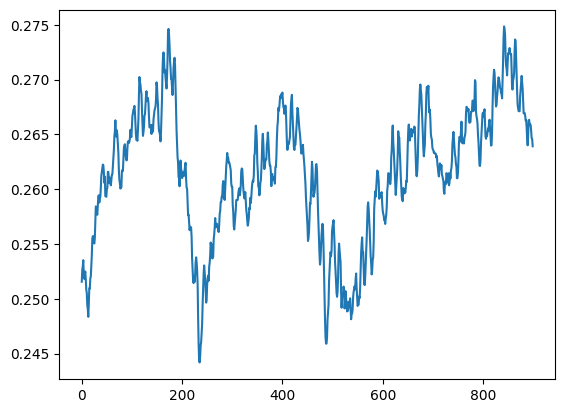

In [ ]:
plt.plot(task2_data[3][0][4, 0, :])

In [ ]:
task1_data_x = np.concatenate([x[0] for x in task1_data])
task1_data_y = np.concatenate([x[1] for x in task1_data])

task2_data_x = np.concatenate([x[0] for x in task2_data])
task2_data_y = np.concatenate([x[1] for x in task2_data])
#

In [ ]:
task1_data_x.shape, task1_data_y.shape, task2_data_x.shape, task2_data_y.shape

((300, 10, 900), (300,), (300, 10, 900), (300,))

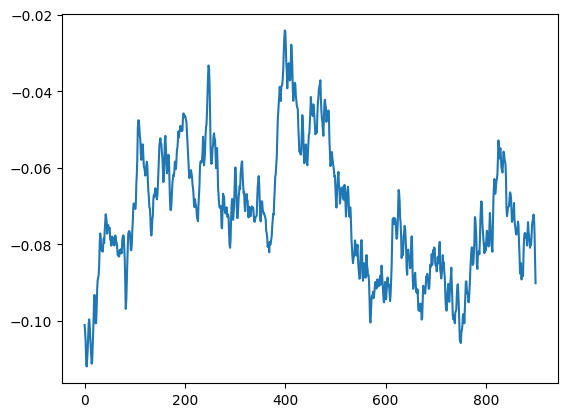

In [ ]:
plt.plot(task1_data_x[-80, 0, :])

In [ ]:
class PretextDataset(Dataset):
  def __init__(self, data, labels):
    self.data = data
    self.labels = labels
  def __len__(self):
    return self.data.shape[0]

  def __getitem__(self, idx):
    #m = np.mean(self.data[idx], axis = -1)
    #s = np.std(self.data[idx], axis = -1)
    #out = (self.data[idx] - m[:, np.newaxis])/s[:, np.newaxis]
    sample = torch.tensor(self.data[idx], dtype=torch.float32)
    label = torch.tensor(self.labels[idx], dtype=torch.long)
    return sample,label

In [ ]:
task1ds = PretextDataset(task1_data_x, task1_data_y)
task2ds = PretextDataset(task2_data_x, task2_data_y)

In [ ]:
np.unique(task1ds.labels), np.unique(task2_data_y)

(array([0., 1., 2., 3., 4.]), array([0., 1., 2., 3.]))

In [ ]:
task1ds[0][0].shape

torch.Size([10, 900])

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from transformers import get_scheduler

In [ ]:
class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, kernels_per_layer, kernel_size, nout):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin * kernels_per_layer, kernel_size=kernel_size, padding="valid", groups=nin) #change back to valid
        self.pointwise = nn.Conv2d(nin * kernels_per_layer, nout, kernel_size=1)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

In [ ]:
class ModelE1(nn.Module):
  def __init__(self):
    super(ModelE1, self).__init__()
    self.conv1 = depthwise_separable_conv(1, 4, (1, int(Fs/2)), 4) #nn.Conv2d(1, 64, (1, int(Fs/2)), padding="valid")#
    self.conv2 = depthwise_separable_conv(4, 8,(num_channels, 1), 8) #nn.Conv2d(64, 64, (num_channels, 1), padding="valid")#
    self.conv3 = depthwise_separable_conv(8, 16, (1, 30), 16) #nn.Conv2d(64, 64, (1, 30), padding="valid")#
    self.conv4 = depthwise_separable_conv(16, 32, (1, 15), 32) #nn.Conv2d(64, 64, (1, 15), padding="valid")#
    self.conv5 = depthwise_separable_conv(32, model1_outputsize, (1, 5), model1_outputsize) #nn.Conv2d(64, 64, (1, 5), padding="valid")#

    self.activation = nn.ELU()

    self.classifier = nn.Linear(64, 5)

    self.embedding = nn.Sequential(self.conv1, self.activation,
                                   self.conv2,  self.activation,
                                   self.conv3, self.activation,
                                   self.conv4, self.activation,
                                   self.conv5, self.activation)

  def forward(self, x, return_features = False):
    x = x.unsqueeze(1)
    emb = self.embedding(x)
    x = emb.mean(dim = -1).squeeze()
    x = self.classifier(x)

    if return_features:
      return x, emb
    else:
      return x

In [ ]:
class ModelE2(nn.Module):
  def __init__(self, num_classes = 4):
    super(ModelE2, self).__init__()
    self.tconv1 = nn.Conv2d(1, 8, (1, 30), padding="same")
    self.sconv1 = nn.Conv2d(8, 8, (num_channels, 1), padding="valid")
    self.tconv2 = nn.Conv2d(8, 16, (1, 15), padding="same")
    self.sconv2 = nn.Conv2d(16, 16, (num_channels, 1), padding="valid")
    self.tconv3 = nn.Conv2d(16, 32, (1, 5), padding="same")
    self.sconv3 = nn.Conv2d(32, 32, (num_channels, 1), padding="valid") #change back to valid

    self.activation = nn.ELU()

    self.classifier = nn.Linear(56, num_classes)

  def forward(self, x, return_features = False):
    x = x.unsqueeze(1)

    t1 = self.tconv1(x)
    t1 = self.activation(t1)

    t2 = self.tconv2(t1)
    t2 = self.activation(t2)

    t3 = self.tconv3(t2)
    t3 = self.activation(t3)

    s1 = self.sconv1(t1)
    s1 = self.activation(s1)

    s2 = self.sconv2(t2)
    s2 = self.activation(s2)

    s3 = self.sconv3(t3)
    s3 = self.activation(s3)

    feats = torch.cat([s1, s2, s3], dim = 1)
    s = feats.mean(dim = -1).squeeze()
    s = self.classifier(s)

    if return_features:
      return s, feats
    else:
      return s

In [ ]:
def statistics(f1, f2):
  mu = torch.squeeze(torch.cat((f1.mean(dim = -1), f2.mean(dim=-1)), 1))
  sigma = torch.squeeze(torch.cat((f1.std(dim = -1), f2.std(dim=-1)), 1))
  #sigma = tf.squeeze(tf.concat((tf.math.reduce_std(f1, -2), tf.math.reduce_std(f2, -2)), -1))
  # similar to global average pooling on the temporal dimension
  f_concat = mu
  return mu, sigma, f_concat

def normalization(f_concat, mu_star, sigma_star):
  out = (f_concat - mu_star)/(sigma_star + torch.tensor(1e-10, device = f_concat.device))
  return out

In [ ]:
from transformers import set_seed

In [ ]:
set_seed(42)

In [ ]:
mm1 = ModelE1()
mm2 = ModelE2(4)

In [ ]:
task1_dl = DataLoader(task1ds, batch_size = 64, shuffle = True)
task2_dl = DataLoader(task2ds, batch_size = 64, shuffle = True)

In [ ]:
num_epochs1 = 200
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
optimizer1 = optim.AdamW(mm1.parameters(), lr = 1e-1, weight_decay=0.01)
optimizer2 = optim.AdamW(mm2.parameters(), lr = 1e-1, weight_decay = 0.01)

scheduler1 = get_scheduler("linear", optimizer1, num_warmup_steps=0, num_training_steps=num_epochs1*len(task1_dl))
scheduler2 = get_scheduler("linear", optimizer2, num_warmup_steps=0, num_training_steps=num_epochs*len(task2_dl))

In [ ]:
mm1.train()
for epoch in range(num_epochs1):
  for batch in task1_dl:

    mm1.to(device)

    optimizer1.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    out = mm1(x)
    loss = F.cross_entropy(out, y)
    loss.backward()
    optimizer1.step()
    scheduler1.step()
  print(f"Epoch {epoch+1} loss: {loss.item()}")

Epoch 1 loss: 40809.47265625
Epoch 2 loss: 3604.675537109375
Epoch 3 loss: 1475271.75
Epoch 4 loss: 428.08575439453125
Epoch 5 loss: 176.66651916503906
Epoch 6 loss: 129.86212158203125
Epoch 7 loss: 87.92449951171875
Epoch 8 loss: 29.512107849121094
Epoch 9 loss: 38125180.0
Epoch 10 loss: 18.076631546020508
Epoch 11 loss: 18.391115188598633
Epoch 12 loss: 14.830248832702637
Epoch 13 loss: 17.655025482177734
Epoch 14 loss: 17.191007614135742
Epoch 15 loss: 19.75379180908203
Epoch 16 loss: 17.447221755981445
Epoch 17 loss: 17.473752975463867
Epoch 18 loss: 16.090938568115234
Epoch 19 loss: 16.142576217651367
Epoch 20 loss: 13.022902488708496
Epoch 21 loss: 11.59434986114502
Epoch 22 loss: 15.656882286071777
Epoch 23 loss: 11.004977226257324
Epoch 24 loss: 12.029277801513672
Epoch 25 loss: 11.980257987976074
Epoch 26 loss: 11.823639869689941
Epoch 27 loss: 10.87825870513916
Epoch 28 loss: 13.141989707946777
Epoch 29 loss: 10.833165168762207
Epoch 30 loss: 10.002285957336426
Epoch 31 loss:

In [ ]:
mm2.train()
for epoch in range(num_epochs):
  for batch in task2_dl:

    mm2.to(device)

    optimizer2.zero_grad()

    x, y = batch
    x = x.to(device)
    y = y.to(device)

    out = mm2(x)
    loss = F.cross_entropy(out, y)
    loss.backward()
    optimizer2.step()
    scheduler2.step()
  print(f"Epoch {epoch+1} loss: {loss.item()}")

Epoch 1 loss: 35.80156326293945
Epoch 2 loss: 88.52625274658203
Epoch 3 loss: 3.2002203464508057
Epoch 4 loss: 1.3816012144088745
Epoch 5 loss: 0.7743499279022217
Epoch 6 loss: 0.5222066640853882
Epoch 7 loss: 0.26727205514907837
Epoch 8 loss: 0.25294408202171326
Epoch 9 loss: 0.407206654548645
Epoch 10 loss: 0.14544501900672913
Epoch 11 loss: 0.1833675056695938
Epoch 12 loss: 0.1337878555059433
Epoch 13 loss: 0.11746473610401154
Epoch 14 loss: 0.0817602202296257
Epoch 15 loss: 0.04930504783987999
Epoch 16 loss: 0.08448353409767151
Epoch 17 loss: 0.10164809972047806
Epoch 18 loss: 0.1044878289103508
Epoch 19 loss: 0.07128966599702835
Epoch 20 loss: 0.0586867593228817


In [ ]:
class ModelC(nn.Module):
  def __init__(self, num_classes = 2):
    super(ModelC, self).__init__()
    input_size = model1_outputsize + 56
    self.classifiers = nn.ModuleList([nn.Linear(input_size, num_classes) for _ in range(num_clusters)])
    self.m1 = mm1
    self.m2 = mm2
    self.kmeans = KMeans(n_clusters = num_clusters, init = "k-means++", n_init = 10)

  def forward(self, x):
    _, f1 = self.m1(x, True)
    _, f2 = self.m2(x, True)
    #print(f1.shape, f2.shape)
    mu, sigma, f_concat = statistics(f1, f2)
    #print(f_concat.shape)

    self.kmeans.fit(np.concatenate((mu.detach().cpu().numpy(), sigma.detach().cpu().numpy()), -1))
    stats = self.kmeans.cluster_centers_[self.kmeans.labels_]

    mu_star, sigma_star = torch.tensor(stats[:, :input_size], device=x.device), torch.tensor(stats[:, input_size:], device=x.device)
    f_aln = normalization(f_concat, mu_star, sigma_star)
    #print(f_aln[0])

    clusters = torch.tensor(self.kmeans.labels_)

    out = []
    for sample_cluster_idx in range(clusters.shape[0]):
      out.append(self.classifiers[clusters[sample_cluster_idx]](f_aln[sample_cluster_idx]))
    return torch.stack(out, 0)

In [ ]:
mmc = ModelC()

In [ ]:
import sklearn
from sklearn.metrics import balanced_accuracy_score

In [ ]:
trn_dataset = CustomBIPDataset(foundation_files[0:2], event_files[0:2])
val_dataset = CustomBIPDataset(foundation_files[2:3], event_files[2:3])

weights = sklearn.utils.class_weight.compute_class_weight('balanced', classes = np.unique(trn_dataset.labels), y = trn_dataset.labels)

In [ ]:
trn_dataset[0][0].shape

torch.Size([10, 900])

In [ ]:
trn_dl = DataLoader(trn_dataset, batch_size = 64, shuffle = True)
val_dl = DataLoader(val_dataset, batch_size = 64, shuffle = False)

In [ ]:
criterion = nn.CrossEntropyLoss(weight=torch.tensor(weights, dtype=torch.float32, device=device))

optimizer = optim.Adam(mmc.parameters(), lr=1e-5, weight_decay = 1e-3, betas = (0.9, 0.999))

scheduler = get_scheduler("linear", optimizer, num_warmup_steps=0, num_training_steps=num_epochs1*len(trn_dl))

In [ ]:
mean_trn_loss = []
mean_val_loss = []
mean_trn_acc = []
mean_val_acc = []

In [ ]:
for epoch in range(num_epochs1):
      mmc.train()
      per_epoch_trn_loss = []
      per_epoch_val_loss = []
      per_epoch_trn_acc = []
      per_epoch_val_acc = []
      for batch_idx, (data, target) in enumerate(trn_dl):
          mmc.to(device)
          data = data.to(device)
          target = target.to(device)
          optimizer.zero_grad()
          #print(f"number of positives: {target.sum():.4f}")

          output = mmc(data)
          loss = criterion(output, target)
          per_epoch_trn_loss.append(loss.item())

          loss.backward()

          trn_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
          #trn_acc = balanced_accuracy_score(target, output>=0)
          per_epoch_trn_acc.append(trn_acc.item())

          optimizer.step()
          scheduler.step()

      mmc.eval()
      for batch_idx, (data, target) in enumerate(val_dl):
          data = data.to(device)
          target = target.to(device)
          with torch.no_grad():
              output = mmc(data)
              loss = criterion(output, target)
              per_epoch_val_loss.append(loss.item())

              #val_acc = custom_balanced_accuracy(output.argmax(dim=-1), target)
              val_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
              #val_acc = balanced_accuracy_score(target, output>=0)
              per_epoch_val_acc.append(val_acc.item())


      mean_trn_loss.append(np.mean(per_epoch_trn_loss))
      mean_val_loss.append(np.mean(per_epoch_val_loss))
      #mean_norm.append(np.mean(per_epoch_norms))

      mean_trn_acc.append(np.mean(per_epoch_trn_acc))
      mean_val_acc.append(np.mean(per_epoch_val_acc))


      print(f'Epoch {epoch+1}/{num_epochs1}, Train Loss: {np.mean(per_epoch_trn_loss):.4f}, Val Loss: {np.mean(per_epoch_val_loss):.4f}, Trn Acc: {np.mean(per_epoch_trn_acc):.4f},  Val Acc: {np.mean(per_epoch_val_acc):.4f}')

Epoch 1/200, Train Loss: 24.4686, Val Loss: 0.7248, Trn Acc: 0.4831,  Val Acc: 0.4393
Epoch 2/200, Train Loss: 227.7731, Val Loss: 0.7075, Trn Acc: 0.4433,  Val Acc: 0.5592
Epoch 3/200, Train Loss: 355.3634, Val Loss: 0.7148, Trn Acc: 0.4025,  Val Acc: 0.5099
Epoch 4/200, Train Loss: 134.7694, Val Loss: 0.7251, Trn Acc: 0.5743,  Val Acc: 0.4557
Epoch 5/200, Train Loss: 52.7015, Val Loss: 0.7185, Trn Acc: 0.4609,  Val Acc: 0.5568
Epoch 6/200, Train Loss: 269.0967, Val Loss: 0.7219, Trn Acc: 0.5139,  Val Acc: 0.4641
Epoch 7/200, Train Loss: 284.0615, Val Loss: 0.7231, Trn Acc: 0.4470,  Val Acc: 0.4447
Epoch 8/200, Train Loss: 564.7821, Val Loss: 0.7190, Trn Acc: 0.4898,  Val Acc: 0.5451
Epoch 9/200, Train Loss: 625.6543, Val Loss: 0.7184, Trn Acc: 0.4958,  Val Acc: 0.5868
Epoch 10/200, Train Loss: 636.3154, Val Loss: 0.7214, Trn Acc: 0.4908,  Val Acc: 0.4797
Epoch 11/200, Train Loss: 102.3999, Val Loss: 0.7228, Trn Acc: 0.5563,  Val Acc: 0.5451
Epoch 12/200, Train Loss: 195.5098, Val Los

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 190/200, Train Loss: 6.6978, Val Loss: 0.6990, Trn Acc: 0.5273,  Val Acc: 0.5172
Epoch 191/200, Train Loss: 43.4730, Val Loss: 1.2940, Trn Acc: 0.5153,  Val Acc: 0.5004
Epoch 192/200, Train Loss: 352.0114, Val Loss: 0.7063, Trn Acc: 0.5294,  Val Acc: 0.5484
Epoch 193/200, Train Loss: 164.3621, Val Loss: 0.7121, Trn Acc: 0.5651,  Val Acc: 0.5332
Epoch 194/200, Train Loss: 87.9161, Val Loss: 0.7012, Trn Acc: 0.5164,  Val Acc: 0.5592
Epoch 195/200, Train Loss: 184.0415, Val Loss: 0.7239, Trn Acc: 0.4511,  Val Acc: 0.4641
Epoch 196/200, Train Loss: 284.4772, Val Loss: 0.7196, Trn Acc: 0.5291,  Val Acc: 0.4810
Epoch 197/200, Train Loss: 486.7726, Val Loss: 0.7211, Trn Acc: 0.4266,  Val Acc: 0.5004
Epoch 198/200, Train Loss: 557.7179, Val Loss: 0.7125, Trn Acc: 0.5076,  Val Acc: 0.5126
Epoch 199/200, Train Loss: 88.7512, Val Loss: 0.7197, Trn Acc: 0.5144,  Val Acc: 0.4339
Epoch 200/200, Train Loss: 321.7206, Val Loss: 0.7211, Trn Acc: 0.5734,  Val Acc: 0.4868


In [ ]:
np.max(mean_val_acc)

0.5975120309797729

In [ ]:
for epoch in range(num_epochs1):
      mmc.train()
      per_epoch_trn_loss = []
      per_epoch_val_loss = []
      per_epoch_trn_acc = []
      per_epoch_val_acc = []
      for batch_idx, (data, target) in enumerate(trn_dl):
          mmc.to(device)
          data = data.to(device)
          target = target.to(device)
          optimizer.zero_grad()
          #print(f"number of positives: {target.sum():.4f}")

          output = mmc(data)
          loss = criterion(output, target)
          per_epoch_trn_loss.append(loss.item())

          loss.backward()

          trn_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
          #trn_acc = balanced_accuracy_score(target, output>=0)
          per_epoch_trn_acc.append(trn_acc.item())

          optimizer.step()
          scheduler.step()

      mmc.eval()
      for batch_idx, (data, target) in enumerate(val_dl):
          data = data.to(device)
          target = target.to(device)
          with torch.no_grad():
              output = mmc(data)
              loss = criterion(output, target)
              per_epoch_val_loss.append(loss.item())

              #val_acc = custom_balanced_accuracy(output.argmax(dim=-1), target)
              val_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
              #val_acc = balanced_accuracy_score(target, output>=0)
              per_epoch_val_acc.append(val_acc.item())


      mean_trn_loss.append(np.mean(per_epoch_trn_loss))
      mean_val_loss.append(np.mean(per_epoch_val_loss))
      #mean_norm.append(np.mean(per_epoch_norms))

      mean_trn_acc.append(np.mean(per_epoch_trn_acc))
      mean_val_acc.append(np.mean(per_epoch_val_acc))


      print(f'Epoch {epoch+1}/{num_epochs1}, Train Loss: {np.mean(per_epoch_trn_loss):.4f}, Val Loss: {np.mean(per_epoch_val_loss):.4f}, Trn Acc: {np.mean(per_epoch_trn_acc):.4f},  Val Acc: {np.mean(per_epoch_val_acc):.4f}')

Epoch 1/200, Train Loss: 65.7100, Val Loss: 0.7096, Trn Acc: 0.4569,  Val Acc: 0.4684
Epoch 2/200, Train Loss: 32.7177, Val Loss: 0.7124, Trn Acc: 0.4197,  Val Acc: 0.5140
Epoch 3/200, Train Loss: 53.0185, Val Loss: 0.7077, Trn Acc: 0.4087,  Val Acc: 0.4814
Epoch 4/200, Train Loss: 56.9321, Val Loss: 0.7083, Trn Acc: 0.4428,  Val Acc: 0.4545
Epoch 5/200, Train Loss: 42.7423, Val Loss: 0.7203, Trn Acc: 0.4650,  Val Acc: 0.4735
Epoch 6/200, Train Loss: 51.9378, Val Loss: 0.7181, Trn Acc: 0.4073,  Val Acc: 0.4309
Epoch 7/200, Train Loss: 12.3040, Val Loss: 0.7182, Trn Acc: 0.4638,  Val Acc: 0.4333
Epoch 8/200, Train Loss: 23.9968, Val Loss: 0.7009, Trn Acc: 0.4876,  Val Acc: 0.5021
Epoch 9/200, Train Loss: 101.8664, Val Loss: 0.7029, Trn Acc: 0.4837,  Val Acc: 0.5282
Epoch 10/200, Train Loss: 27.5853, Val Loss: 0.7093, Trn Acc: 0.4771,  Val Acc: 0.5173
Epoch 11/200, Train Loss: 24.8665, Val Loss: 0.6930, Trn Acc: 0.4664,  Val Acc: 0.5412
Epoch 12/200, Train Loss: 41.1130, Val Loss: 0.7093

In [ ]:
np.max(mean_val_acc)

0.6287103353635611

In [ ]:
for epoch in range(num_epochs):
      mmc.train()
      per_epoch_trn_loss = []
      per_epoch_val_loss = []
      per_epoch_trn_acc = []
      per_epoch_val_acc = []
      for batch_idx, (data, target) in enumerate(trn_dl):
          mmc.to(device)
          data = data.to(device)
          target = target.to(device)
          optimizer.zero_grad()
          #print(f"number of positives: {target.sum():.4f}")

          output = mmc(data)
          loss = criterion(output, target)
          per_epoch_trn_loss.append(loss.item())

          loss.backward()

          trn_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
          #trn_acc = balanced_accuracy_score(target, output>=0)
          per_epoch_trn_acc.append(trn_acc.item())

          optimizer.step()
          scheduler.step()

      mmc.eval()
      for batch_idx, (data, target) in enumerate(val_dl):
          data = data.to(device)
          target = target.to(device)
          with torch.no_grad():
              output = mmc(data)
              loss = criterion(output, target)
              per_epoch_val_loss.append(loss.item())

              #val_acc = custom_balanced_accuracy(output.argmax(dim=-1), target)
              val_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
              #val_acc = balanced_accuracy_score(target, output>=0)
              per_epoch_val_acc.append(val_acc.item())


      mean_trn_loss.append(np.mean(per_epoch_trn_loss))
      mean_val_loss.append(np.mean(per_epoch_val_loss))
      #mean_norm.append(np.mean(per_epoch_norms))

      mean_trn_acc.append(np.mean(per_epoch_trn_acc))
      mean_val_acc.append(np.mean(per_epoch_val_acc))


      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(per_epoch_trn_loss):.4f}, Val Loss: {np.mean(per_epoch_val_loss):.4f}, Trn Acc: {np.mean(per_epoch_trn_acc):.4f},  Val Acc: {np.mean(per_epoch_val_acc):.4f}')

Epoch 1/20, Train Loss: 0.7067, Val Loss: 0.7250, Trn Acc: 0.4513,  Val Acc: 0.4286
Epoch 2/20, Train Loss: 0.7008, Val Loss: 0.7060, Trn Acc: 0.4473,  Val Acc: 0.5300
Epoch 3/20, Train Loss: 0.6791, Val Loss: 0.7138, Trn Acc: 0.5991,  Val Acc: 0.4967
Epoch 4/20, Train Loss: 0.6930, Val Loss: 0.7096, Trn Acc: 0.4614,  Val Acc: 0.5335
Epoch 5/20, Train Loss: 0.7069, Val Loss: 0.7161, Trn Acc: 0.4660,  Val Acc: 0.4868
Epoch 6/20, Train Loss: 0.7010, Val Loss: 0.7124, Trn Acc: 0.4543,  Val Acc: 0.5135
Epoch 7/20, Train Loss: 0.6917, Val Loss: 0.7173, Trn Acc: 0.4615,  Val Acc: 0.4994
Epoch 8/20, Train Loss: 0.6994, Val Loss: 0.7061, Trn Acc: 0.4307,  Val Acc: 0.5364
Epoch 9/20, Train Loss: 0.6975, Val Loss: 6.7671, Trn Acc: 0.4528,  Val Acc: 0.4498
Epoch 10/20, Train Loss: 0.6991, Val Loss: 0.7086, Trn Acc: 0.4943,  Val Acc: 0.5306
Epoch 11/20, Train Loss: 0.7059, Val Loss: 0.7054, Trn Acc: 0.4469,  Val Acc: 0.5847
Epoch 12/20, Train Loss: 0.7027, Val Loss: 0.7143, Trn Acc: 0.4762,  Val A

In [ ]:
for epoch in range(num_epochs):
      mmc.train()
      per_epoch_trn_loss = []
      per_epoch_val_loss = []
      per_epoch_trn_acc = []
      per_epoch_val_acc = []
      for batch_idx, (data, target) in enumerate(trn_dl):
          mmc.to(device)
          data = data.to(device)
          target = target.to(device)
          optimizer.zero_grad()
          #print(f"number of positives: {target.sum():.4f}")

          output = mmc(data)
          loss = criterion(output, target)
          per_epoch_trn_loss.append(loss.item())

          loss.backward()

          trn_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
          #trn_acc = balanced_accuracy_score(target, output>=0)
          per_epoch_trn_acc.append(trn_acc.item())

          optimizer.step()
          scheduler.step()

      mmc.eval()
      for batch_idx, (data, target) in enumerate(val_dl):
          data = data.to(device)
          target = target.to(device)
          with torch.no_grad():
              output = mmc(data)
              loss = criterion(output, target)
              per_epoch_val_loss.append(loss.item())

              #val_acc = custom_balanced_accuracy(output.argmax(dim=-1), target)
              val_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
              #val_acc = balanced_accuracy_score(target, output>=0)
              per_epoch_val_acc.append(val_acc.item())


      mean_trn_loss.append(np.mean(per_epoch_trn_loss))
      mean_val_loss.append(np.mean(per_epoch_val_loss))
      #mean_norm.append(np.mean(per_epoch_norms))

      mean_trn_acc.append(np.mean(per_epoch_trn_acc))
      mean_val_acc.append(np.mean(per_epoch_val_acc))


      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(per_epoch_trn_loss):.4f}, Val Loss: {np.mean(per_epoch_val_loss):.4f}, Trn Acc: {np.mean(per_epoch_trn_acc):.4f},  Val Acc: {np.mean(per_epoch_val_acc):.4f}')

Epoch 1/20, Train Loss: 0.6891, Val Loss: 0.6901, Trn Acc: 0.5490,  Val Acc: 0.4912
Epoch 2/20, Train Loss: 0.6938, Val Loss: 0.6912, Trn Acc: 0.5761,  Val Acc: 0.5039
Epoch 3/20, Train Loss: 0.6888, Val Loss: 0.6953, Trn Acc: 0.6025,  Val Acc: 0.4509
Epoch 4/20, Train Loss: 0.6895, Val Loss: 0.6919, Trn Acc: 0.5341,  Val Acc: 0.5066
Epoch 5/20, Train Loss: 0.6927, Val Loss: 0.6907, Trn Acc: 0.5093,  Val Acc: 0.5208
Epoch 6/20, Train Loss: 0.6910, Val Loss: 0.6933, Trn Acc: 0.5292,  Val Acc: 0.5287
Epoch 7/20, Train Loss: 0.6932, Val Loss: 0.6911, Trn Acc: 0.5121,  Val Acc: 0.4848
Epoch 8/20, Train Loss: 0.6880, Val Loss: 0.6929, Trn Acc: 0.5731,  Val Acc: 0.4741
Epoch 9/20, Train Loss: 0.6863, Val Loss: 0.6854, Trn Acc: 0.5377,  Val Acc: 0.4370
Epoch 10/20, Train Loss: 0.6874, Val Loss: 0.6946, Trn Acc: 0.5273,  Val Acc: 0.5416
Epoch 11/20, Train Loss: 0.6881, Val Loss: 0.6871, Trn Acc: 0.5381,  Val Acc: 0.4459
Epoch 12/20, Train Loss: 0.6931, Val Loss: 0.6924, Trn Acc: 0.5285,  Val A

In [ ]:
for epoch in range(num_epochs):
      mmc.train()
      per_epoch_trn_loss = []
      per_epoch_val_loss = []
      per_epoch_trn_acc = []
      per_epoch_val_acc = []
      for batch_idx, (data, target) in enumerate(trn_dl):
          mmc.to(device)
          data = data.to(device)
          target = target.to(device)
          optimizer.zero_grad()
          #print(f"number of positives: {target.sum():.4f}")

          output = mmc(data)
          loss = criterion(output, target)
          per_epoch_trn_loss.append(loss.item())

          loss.backward()

          trn_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
          #trn_acc = balanced_accuracy_score(target, output>=0)
          per_epoch_trn_acc.append(trn_acc.item())

          optimizer.step()
          scheduler.step()

      mmc.eval()
      for batch_idx, (data, target) in enumerate(val_dl):
          data = data.to(device)
          target = target.to(device)
          with torch.no_grad():
              output = mmc(data)
              loss = criterion(output, target)
              per_epoch_val_loss.append(loss.item())

              #val_acc = custom_balanced_accuracy(output.argmax(dim=-1), target)
              val_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
              #val_acc = balanced_accuracy_score(target, output>=0)
              per_epoch_val_acc.append(val_acc.item())


      mean_trn_loss.append(np.mean(per_epoch_trn_loss))
      mean_val_loss.append(np.mean(per_epoch_val_loss))
      #mean_norm.append(np.mean(per_epoch_norms))

      mean_trn_acc.append(np.mean(per_epoch_trn_acc))
      mean_val_acc.append(np.mean(per_epoch_val_acc))


      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(per_epoch_trn_loss):.4f}, Val Loss: {np.mean(per_epoch_val_loss):.4f}, Trn Acc: {np.mean(per_epoch_trn_acc):.4f},  Val Acc: {np.mean(per_epoch_val_acc):.4f}')

Epoch 1/20, Train Loss: 0.6993, Val Loss: 0.7001, Trn Acc: 0.4548,  Val Acc: 0.5417
Epoch 2/20, Train Loss: 0.6941, Val Loss: 0.7155, Trn Acc: 0.5617,  Val Acc: 0.5344
Epoch 3/20, Train Loss: 0.6905, Val Loss: 0.9088, Trn Acc: 0.5170,  Val Acc: 0.5060
Epoch 4/20, Train Loss: 0.6997, Val Loss: 0.7081, Trn Acc: 0.4434,  Val Acc: 0.5039
Epoch 5/20, Train Loss: 0.6967, Val Loss: 0.7223, Trn Acc: 0.4721,  Val Acc: 0.5042
Epoch 6/20, Train Loss: 0.6978, Val Loss: 3.8512, Trn Acc: 0.4491,  Val Acc: 0.5222
Epoch 7/20, Train Loss: 0.6996, Val Loss: 0.7040, Trn Acc: 0.4389,  Val Acc: 0.4885
Epoch 8/20, Train Loss: 0.6980, Val Loss: 2.7281, Trn Acc: 0.4292,  Val Acc: 0.4975
Epoch 9/20, Train Loss: 0.6996, Val Loss: 0.7006, Trn Acc: 0.4027,  Val Acc: 0.4836
Epoch 10/20, Train Loss: 0.6973, Val Loss: 0.7065, Trn Acc: 0.4823,  Val Acc: 0.5375
Epoch 11/20, Train Loss: 0.6898, Val Loss: 0.7120, Trn Acc: 0.5142,  Val Acc: 0.5297
Epoch 12/20, Train Loss: 0.7003, Val Loss: 0.7042, Trn Acc: 0.4125,  Val A

In [ ]:
for epoch in range(num_epochs):
      mmc.train()
      per_epoch_trn_loss = []
      per_epoch_val_loss = []
      per_epoch_trn_acc = []
      per_epoch_val_acc = []
      for batch_idx, (data, target) in enumerate(trn_dl):
          mmc.to(device)
          data = data.to(device)
          target = target.to(device)
          optimizer.zero_grad()
          #print(f"number of positives: {target.sum():.4f}")

          output = mmc(data)
          loss = criterion(output, target)
          per_epoch_trn_loss.append(loss.item())

          loss.backward()

          trn_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
          #trn_acc = balanced_accuracy_score(target, output>=0)
          per_epoch_trn_acc.append(trn_acc.item())

          optimizer.step()
          scheduler.step()

      mmc.eval()
      for batch_idx, (data, target) in enumerate(val_dl):
          data = data.to(device)
          target = target.to(device)
          with torch.no_grad():
              output = mmc(data)
              loss = criterion(output, target)
              per_epoch_val_loss.append(loss.item())

              #val_acc = custom_balanced_accuracy(output.argmax(dim=-1), target)
              val_acc = balanced_accuracy_score(target.cpu(), output.argmax(dim=-1).cpu())
              #val_acc = balanced_accuracy_score(target, output>=0)
              per_epoch_val_acc.append(val_acc.item())


      mean_trn_loss.append(np.mean(per_epoch_trn_loss))
      mean_val_loss.append(np.mean(per_epoch_val_loss))
      #mean_norm.append(np.mean(per_epoch_norms))

      mean_trn_acc.append(np.mean(per_epoch_trn_acc))
      mean_val_acc.append(np.mean(per_epoch_val_acc))


      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(per_epoch_trn_loss):.4f}, Val Loss: {np.mean(per_epoch_val_loss):.4f}, Trn Acc: {np.mean(per_epoch_trn_acc):.4f},  Val Acc: {np.mean(per_epoch_val_acc):.4f}')

Epoch 1/20, Train Loss: 219.2386, Val Loss: 0.6893, Trn Acc: 0.5420,  Val Acc: 0.5849
Epoch 2/20, Train Loss: 480.4193, Val Loss: 0.6871, Trn Acc: 0.5104,  Val Acc: 0.4666
Epoch 3/20, Train Loss: 208.5374, Val Loss: 0.6917, Trn Acc: 0.4279,  Val Acc: 0.4870
Epoch 4/20, Train Loss: 147.6573, Val Loss: 0.6844, Trn Acc: 0.4363,  Val Acc: 0.4456
Epoch 5/20, Train Loss: 132.8237, Val Loss: 0.6910, Trn Acc: 0.5563,  Val Acc: 0.5334
Epoch 6/20, Train Loss: 311.5102, Val Loss: 0.6851, Trn Acc: 0.5157,  Val Acc: 0.4345
Epoch 7/20, Train Loss: 31.7638, Val Loss: 0.6878, Trn Acc: 0.5474,  Val Acc: 0.4603
Epoch 8/20, Train Loss: 53.4202, Val Loss: 0.6899, Trn Acc: 0.4815,  Val Acc: 0.5419
Epoch 9/20, Train Loss: 516.8097, Val Loss: 0.6897, Trn Acc: 0.3985,  Val Acc: 0.5392
Epoch 10/20, Train Loss: 3.8401, Val Loss: 0.6895, Trn Acc: 0.5083,  Val Acc: 0.4898
Epoch 11/20, Train Loss: 134.9771, Val Loss: 0.6908, Trn Acc: 0.5121,  Val Acc: 0.4375
Epoch 12/20, Train Loss: 2.0205, Val Loss: 0.6830, Trn A

In [ ]:
for epoch in range(num_epochs):
      mmc.train()
      per_epoch_trn_loss = []
      per_epoch_val_loss = []
      per_epoch_trn_acc = []
      per_epoch_val_acc = []
      for batch_idx, (data, target) in enumerate(trn_dl):
          optimizer.zero_grad()
          #print(f"number of positives: {target.sum():.4f}")

          output = mmc(data)
          loss = criterion(output, target)
          per_epoch_trn_loss.append(loss.item())

          loss.backward()

          trn_acc = balanced_accuracy_score(target, output.argmax(dim=-1))
          #trn_acc = balanced_accuracy_score(target, output>=0)
          per_epoch_trn_acc.append(trn_acc.item())

          optimizer.step()
          scheduler.step()

      mmc.eval()
      for batch_idx, (data, target) in enumerate(val_dl):
          with torch.no_grad():
              output = mmc(data)
              loss = criterion(output, target)
              per_epoch_val_loss.append(loss.item())

              #val_acc = custom_balanced_accuracy(output.argmax(dim=-1), target)
              val_acc = balanced_accuracy_score(target, output.argmax(dim=-1))
              #val_acc = balanced_accuracy_score(target, output>=0)
              per_epoch_val_acc.append(val_acc.item())


      mean_trn_loss.append(np.mean(per_epoch_trn_loss))
      mean_val_loss.append(np.mean(per_epoch_val_loss))
      #mean_norm.append(np.mean(per_epoch_norms))

      mean_trn_acc.append(np.mean(per_epoch_trn_acc))
      mean_val_acc.append(np.mean(per_epoch_val_acc))


      print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {np.mean(per_epoch_trn_loss):.4f}, Val Loss: {np.mean(per_epoch_val_loss):.4f}, Trn Acc: {np.mean(per_epoch_trn_acc):.4f},  Val Acc: {np.mean(per_epoch_val_acc):.4f}')

Epoch 1/20, Train Loss: 2262.2971, Val Loss: 0.6916, Trn Acc: 0.4537,  Val Acc: 0.4461
Epoch 2/20, Train Loss: 118.8506, Val Loss: 35.0503, Trn Acc: 0.5777,  Val Acc: 0.5150
Epoch 3/20, Train Loss: 2164.3794, Val Loss: 27.5954, Trn Acc: 0.4023,  Val Acc: 0.4871
Epoch 4/20, Train Loss: 126.3410, Val Loss: 8.5038, Trn Acc: 0.4133,  Val Acc: 0.5377
Epoch 5/20, Train Loss: 725.5681, Val Loss: 5.5742, Trn Acc: 0.5369,  Val Acc: 0.5189
Epoch 6/20, Train Loss: 883.7188, Val Loss: 1.1522, Trn Acc: 0.4826,  Val Acc: 0.4821
Epoch 7/20, Train Loss: 270.4990, Val Loss: 0.8195, Trn Acc: 0.4945,  Val Acc: 0.4886
Epoch 8/20, Train Loss: 110.9517, Val Loss: 3.5818, Trn Acc: 0.5498,  Val Acc: 0.4733


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


Epoch 9/20, Train Loss: 130.6181, Val Loss: 2.6713, Trn Acc: 0.4775,  Val Acc: 0.4706
Epoch 10/20, Train Loss: 152.2191, Val Loss: 0.7082, Trn Acc: 0.4845,  Val Acc: 0.4847
Epoch 11/20, Train Loss: 130.8970, Val Loss: 0.9865, Trn Acc: 0.5872,  Val Acc: 0.4493
Epoch 12/20, Train Loss: 30.1803, Val Loss: 0.6997, Trn Acc: 0.6035,  Val Acc: 0.5125
Epoch 13/20, Train Loss: 187.7338, Val Loss: 0.6992, Trn Acc: 0.4224,  Val Acc: 0.5150
Epoch 14/20, Train Loss: 212.8765, Val Loss: 1.4001, Trn Acc: 0.4536,  Val Acc: 0.4783
Epoch 15/20, Train Loss: 2914.9250, Val Loss: 32.3604, Trn Acc: 0.4894,  Val Acc: 0.4729
Epoch 16/20, Train Loss: 174.8447, Val Loss: 2.0369, Trn Acc: 0.4676,  Val Acc: 0.5250
Epoch 17/20, Train Loss: 303.7262, Val Loss: 31.6369, Trn Acc: 0.5008,  Val Acc: 0.5113
Epoch 18/20, Train Loss: 1020.6682, Val Loss: 0.6809, Trn Acc: 0.4168,  Val Acc: 0.4666
Epoch 19/20, Train Loss: 123.0227, Val Loss: 39.8086, Trn Acc: 0.4912,  Val Acc: 0.5110
Epoch 20/20, Train Loss: 122.5301, Val L

In [ ]:
!cp /content/data_Adeola_July21.zip drive/MyDrive/data_Adeola_July21.zip

In [ ]:
!rm drive/MyDrive/data_Adeola_July21

In [ ]:
!cp drive/MyDrive/data_Adeola_July21.zip /content/data_Adeola_July21.zip